## Introduction

In this tutorial, we demonstrate how to use autoencoer (AE) on EMT dataset. The EMT dataset is time-series scRNA-seq dataset from an A549 cancer cell line where cells were exposed to TGFB1 to induce EMT at the first five time points [1].

We used the standard Seurat protocol for data preprocessing. The raw count matrix is selected via quality control, and the total count of each cell is normalized. The normalized count matrix is then log-transformed to log expression. The top $3000$ highly variable genes are selected for EMT dataset, where $n_{input}=3000$ is the input dimension for AE.

References:
1. Cook, D.P. and B.C. Vanderhyden, Context specificity of the EMT transcriptional response. Nature communications, 2020. 11(1): p. 2142

In [1]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import scanpy as sc
from matplotlib.pyplot import rc_context
import os
from pathlib import Path
import matplotlib.pyplot as plt
import gc
import sys
sys.path.append(r'C:\Users\jferrarigian\repos\TIGON')
from AE import AutoEncoder, Trainer


def load_data(dataset:str,path_to_data):

    if dataset=='EMT':
        data = pd.read_csv(path_to_data+'AE_EMT_normalized.csv', index_col=0).transpose()
        y = pd.read_csv(path_to_data+'AE_EMT_time.csv', index_col=0)
        row_order = data.index
        y_reordered = y.loc[row_order]
        adata = sc.AnnData(data)
        adata.obs['time'] = y_reordered


        X=adata.X
    elif dataset=='iPSC':
        filename = path_to_data+'data.xlsx'
        df = pd.read_excel(filename, header=[0, 1], index_col=0)
        times = df.columns.get_level_values(0)
        times = times.to_list()
        df.columns = df.columns.droplevel(0)
        df = df.transpose()
        adata = sc.AnnData(df)
        adata.obs['time'] = times

        X=adata.X

    else:
        raise NotImplementedError
    return adata,X
def folder_dir(dataset:str='EMT',
         seed:int=42,
         n_latent:int=6,
         n_hidden:int=300,
         n_layers: int=1,
         activation: str = 'relu',
         dropout:float=0.2,
         weight_decay:float=1e-4,
         lr:float=1e-3,
         batch_size: int=32,):
    folder=Path('results/'+dataset+'_'+str(seed)+\
           '_'+str(n_latent)+'_'+str(n_layers)+'_'+str(n_hidden)+\
           '_'+str(dropout)+'_'+str(weight_decay)+'_'+str(lr)+'_'+str(batch_size)+'/')
    return folder
def generate_plots(folder,model, adata,seed,n_neighbors=10,min_dist=0.5,plots='umap'):
    model.eval()
    with torch.no_grad():
        X_latent_AE=model.get_latent_representation(torch.tensor(adata.X).type(torch.float32).to('cpu'))
    adata.obsm['X_AE']=X_latent_AE.detach().cpu().numpy()
    sc.pp.neighbors(adata, n_neighbors=n_neighbors,use_rep='X_AE')

    if dataset in ['EMT','iPSC']:
        color=['time']
    else:
        raise  NotImplementedError
    if plots=='umap':
        sc.tl.umap(adata,random_state=seed,min_dist=min_dist)
        with rc_context({'figure.figsize': (8, 8*len(color))}):
            sc.pl.umap(adata, color=color,
                       legend_loc='on data',
                       legend_fontsize=12,
                       legend_fontoutline=2, )
        plt.savefig(str(folder) + '/umap.pdf')
        plt.close()
    elif plots=='embedding':
        with rc_context({'figure.figsize': (8*len(color), 8)}):
            sc.pl.embedding(adata, 'X_AE',color=color,
                       # legend_loc='on data',
                       legend_fontsize=12,
                       legend_fontoutline=2, )
            plt.legend(frameon=False)
            plt.xticks([plt.xlim()[0], 0., plt.xlim()[1]])
            plt.yticks([plt.ylim()[0], 0., plt.ylim()[1]])
        plt.savefig(str(folder) + '/embedding.pdf')
        plt.close()

def loss_plots(folder,model):
    fig,axs=plt.subplots(1, 1, figsize=(4, 4))
    axs.set_title('AE loss')
    axs.plot(model.history['epoch'], model.history['train_loss'])
    axs.plot(model.history['epoch'], model.history['val_loss'])
    plt.yscale('log')
    axs.legend(['train loss','val loss'])
    plt.savefig(str(folder)+'/loss.pdf')
    plt.close()

def main(dataset:str='EMT',
         seed:int=42,
         n_latent:int=6,
         n_hidden:int=300,
         n_layers: int=1,
         activation: str='relu',
         dropout:float=0.2,
         weight_decay:float=1e-4,
         lr:float=1e-3,
         max_epoch:int=500,
         batch_size: int=32,
         mode='training',
         path_to_data='Path to data'
         ):
    adata,X = load_data(dataset,path_to_data)

    model=AutoEncoder(in_dim=X.shape[1],
                      n_latent=n_latent,
                      n_hidden=n_hidden,
                      n_layers=n_layers,
                      activate_type=activation,
                      dropout=dropout,
                      norm=True,
                      seed=seed,)

    trainer=Trainer(model,X=X,
                    test_size=0.1,
                    lr=lr,
                    batch_size=batch_size,
                    weight_decay=weight_decay,
                    seed=seed)

    folder=folder_dir(dataset=dataset,
         seed=seed,
         n_latent=n_latent,
         n_hidden=n_hidden,
         n_layers=n_layers,
         dropout=dropout,
         activation=activation,
         weight_decay=weight_decay,
         lr=lr,
         batch_size=batch_size,)

    if mode=='training':
        print('training the model')
        trainer.train(max_epoch=max_epoch,patient=30)

        # model.eval()
        if not os.path.exists(folder):
            folder.mkdir(parents=True)
        torch.save({
            'func_state_dict': model.state_dict(),
            'optimizer_state_dict': trainer.optimizer.state_dict(),
            'loss_history':trainer.model.history,
        }, os.path.join(folder,'model.pt'))
    elif mode=='loading':
        print('loading the model')
        check_pt = torch.load(os.path.join(folder, 'model.pt'))

        model.load_state_dict(check_pt['func_state_dict'])
        trainer.optimizer.load_state_dict(check_pt['optimizer_state_dict'])
        model.history=check_pt['loss_history']
    return model,trainer,adata,folder




c:\Users\jferrarigian\AppData\Local\miniconda3\envs\tigon\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Here we consider the dimension of latent space is 10.

training the model
Epoch 0: train loss = 1.5883, val error = 1.0675
Epoch 1: train loss = 1.4650, val error = 1.0482
Epoch 2: train loss = 1.3916, val error = 0.9730
Epoch 3: train loss = 1.3279, val error = 0.8722
Epoch 4: train loss = 1.2701, val error = 0.8591
Epoch 5: train loss = 1.2145, val error = 0.8098
Epoch 6: train loss = 1.1618, val error = 0.7686
Epoch 7: train loss = 1.1120, val error = 0.7876
Epoch 8: train loss = 1.0656, val error = 0.7294
Epoch 9: train loss = 1.0205, val error = 0.6605
Epoch 10: train loss = 0.9764, val error = 0.6825
Epoch 11: train loss = 0.9362, val error = 0.6685
Epoch 12: train loss = 0.8962, val error = 0.6012
Epoch 13: train loss = 0.8597, val error = 0.5943
Epoch 14: train loss = 0.8234, val error = 0.5593
Epoch 15: train loss = 0.7886, val error = 0.5173
Epoch 16: train loss = 0.7562, val error = 0.5235
Epoch 17: train loss = 0.7242, val error = 0.5067
Epoch 18: train loss = 0.6951, val error = 0.4789
Epoch 19: train loss = 0.6656, val error 

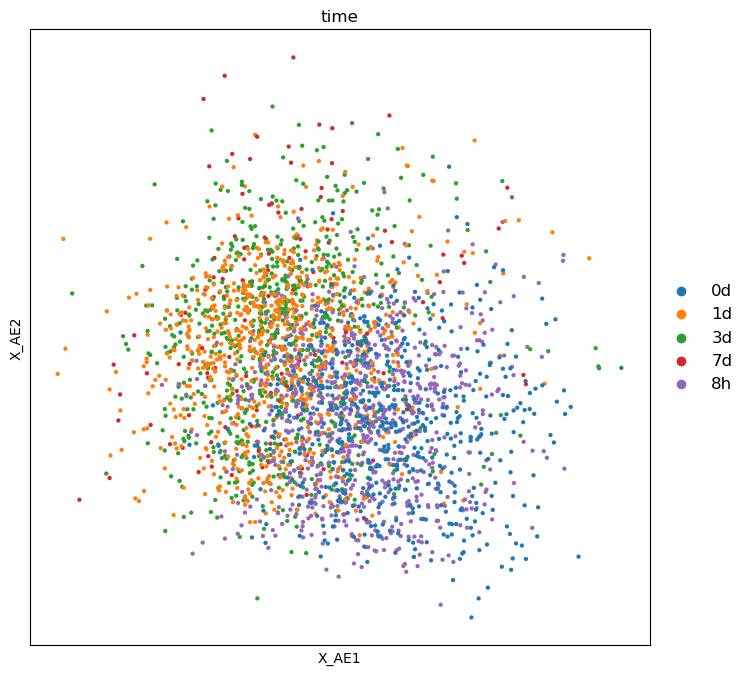

C:\Users\jferrarigian\AppData\Local\Temp\ipykernel_17784\4157823402.py:83: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(frameon=False)
findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


In [2]:
seed=4232
n_layers = 1
batch_size=128


dataset='EMT'

lr=1e-3
n_hidden=300
n_latent = 10


model,trainer, adata,folder=main(dataset=dataset,seed=seed,
                          n_layers=n_layers,n_latent=n_latent,n_hidden=n_hidden,
                          activation='relu',
                          lr=lr,batch_size=batch_size,
                          max_epoch=500,
                          mode='training',
                          path_to_data =  str(Path(r"../EMT_data").absolute().resolve()) + "\\"
                          )

model=model.to('cpu')

generate_plots(folder,model, adata,seed,n_neighbors=20,min_dist=0.5,plots='embedding')
loss_plots(folder,model)


In [9]:
folder.resolve()

WindowsPath('C:/Users/jferrarigian/repos/TIGON/Notebooks/results/EMT_4232_10_1_300_0.2_0.0001_0.001_128')

In [10]:
model.eval()
with torch.no_grad():
    X_latent_AE=model.get_latent_representation(torch.tensor(adata.X).type(torch.float32).to('cpu'))

In [12]:
X_latent_AE.shape

torch.Size([3133, 10])

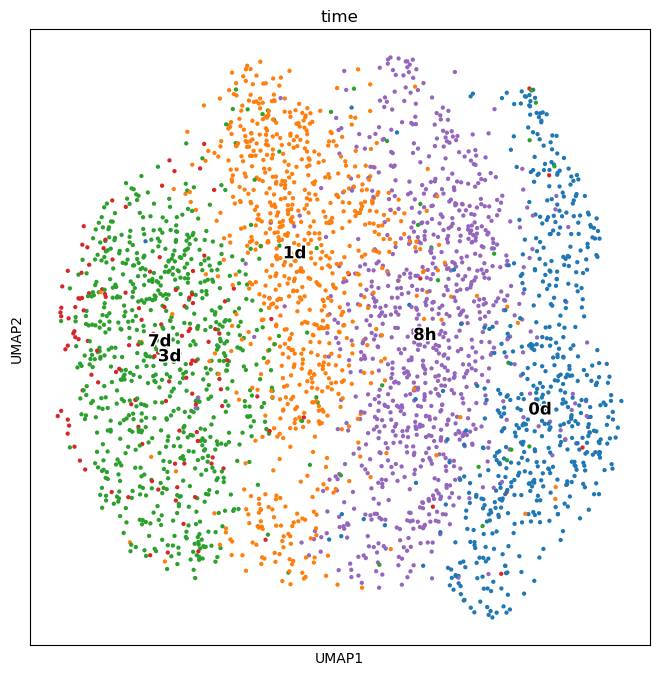

In [13]:
generate_plots(folder,model, adata,seed,n_neighbors=20,min_dist=0.5)

In [14]:
adata.obsm['X_AE']=X_latent_AE.detach().cpu().numpy()

In [15]:
adata

AnnData object with n_obs × n_vars = 3133 × 3000
    obs: 'time'
    uns: 'neighbors', 'time_colors', 'umap'
    obsm: 'X_AE', 'X_umap'
    obsp: 'distances', 'connectivities'

In [20]:
adata.obsm['X_AE'].shape

(3133, 10)

In [23]:
type(adata.obsm['X_AE'])

numpy.ndarray

In [22]:
adata.obs

,time
Mix1_AAAGCAACACTTCGAA,3d
Mix1_AACTCTTCACAGCCCA,3d
Mix1_AAGCCGCAGGAATCGC,3d
Mix1_ACACTGAGTAACGCGA,3d
Mix1_ACACTGATCAACGCTA,3d
...,...
Mix4b_TTGGCAAAGCACACAG,0d
Mix4b_TTGTAGGTCTGTGCAA,0d
Mix4b_TTTACTGCATCGGAAG,0d
Mix4b_TTTGGTTAGTGACATA,0d


In [24]:
type(adata)

anndata._core.anndata.AnnData

In [25]:
X_latent_AE_numpy = X_latent_AE.detach().cpu().numpy()

In [31]:
adata.obs["time"].unique()

['3d', '7d', '1d', '8h', '0d']
Categories (5, object): ['0d', '1d', '3d', '7d', '8h']

In [33]:
ordered_time = [
    "0d",
    "8h",
    "1d",
    "3d",
    "7d",
]

In [34]:
list_obs = [
    X_latent_AE_numpy[
        adata.obs["time"] == t
    ].copy() 
    for t in ordered_time
]

In [38]:
list_obs[1].shape

(885, 10)

In [71]:
array_obs = np.array([list_obs], dtype=object)

In [78]:
np.save(Path(r"../Input/EMT_10_latent.npy").absolute().resolve(), array_obs, allow_pickle=True)

In [ ]:
reload = np.load(Path(r"../Input/EMT_10_latent.npy").absolute().resolve(), allow_pickle=True)

In [75]:
reload.shape

(1, 5)